In [1]:
import gradio as gr
import openai
import base64
import time

/Users/guna_bb/anaconda3/envs/DB/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
openai.api_base = ""  # 또는 ngrok URL
openai.api_key = "EMPTY"  

In [11]:
try:
    models = openai.Model.list()
    print(models)
except Exception as e:
    print(f"Error: {e}")

{
  "object": "list",
  "data": [
    {
      "id": "llava-hf/llava-1.5-7b-hf",
      "object": "model",
      "created": 1732120968,
      "owned_by": "vllm",
      "root": "llava-hf/llava-1.5-7b-hf",
      "parent": null,
      "max_model_len": 4096,
      "permission": [
        {
          "id": "modelperm-a2a4adeb01a0400f8df082b6c91f3c24",
          "object": "model_permission",
          "created": 1732120968,
          "allow_create_engine": false,
          "allow_sampling": true,
          "allow_logprobs": true,
          "allow_search_indices": false,
          "allow_view": true,
          "allow_fine_tuning": false,
          "organization": "*",
          "group": null,
          "is_blocking": false
        }
      ]
    }
  ]
}


In [12]:
model = models.data[0].id


In [13]:
def encode_base64_content_from_file(image_path: str) -> str:
    """Encode a content retrieved from image_path to base64 format."""
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_string

In [22]:
def make_openai_msg(message):
  content = []
  if message["files"]:
    for x in message["files"]:
      image_url = f"data:image/jpeg;base64,{encode_base64_content_from_file(x)}"
      content.append({"type": "image_url",
                      "image_url":{"url": image_url}})
    if message["text"]:
      content.append({"type":"text",
                      "text": message["text"]})
    else:
      content.append({"type":"text",
                      "text":"이 사진에 대해 설명해주세요"})
    print({"role":"user",
          "content":content})
    return {"role":"user",
          "content":content}
  else:
    print({"role": "user",
                "content": message["text"]})
    return {"role": "user",
                "content": message["text"]}
  

In [15]:
def add_message(history, message):
    for x in message["files"]:
        history.append({"role": "user", "content": {"path": x}})
    if message["text"] is not None:
        history.append({"role": "user", "content": message["text"]})
    else: history.append({"role": "user", "content": "이 사진(들)을 설명해주세요"})
    return history, gr.MultimodalTextbox(value=None, interactive=False)

In [27]:
def bot(history: list,user_msg):
    
    chat_completion = openai.ChatCompletion.create(
        model=model,  # Replace with your model ID
        messages=[user_msg],
        max_tokens=128,  # Configurable for more detailed responses
    )
    result = chat_completion.choices[0].message["content"]
    history.append({"role": "assistant", "content": ""})
    for character in result:
        history[-1]["content"] += character
        time.sleep(0.05)
        yield history, {}

In [26]:
openai.ChatCompletion.create(
  model=model,
  messages= [
    {"role": "user", "content": "안녕"}
],
  max_tokens=128,
)

<OpenAIObject chat.completion id=chatcmpl-7fd7acb351114bd38699edb6a59f64d4 at 0x112918280> JSON: {
  "id": "chatcmpl-7fd7acb351114bd38699edb6a59f64d4",
  "object": "chat.completion",
  "created": 1732121465,
  "model": "llava-hf/llava-1.5-7b-hf",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "\n\uc548\ub155\ud558\uc138\uc694! \uac1c\uc778 \ud559\uc2b5\uc73c\ub85c \ud658\uacbd \uacf5\ud559 \ubd84\uc57c\uc5d0 \ub300\ud55c \uc774\ud574\ub97c \ub192\uc774\uace0 \uc788\uc2b5\ub2c8\ub2e4. \uc774\ubc88\uc5d0\ub294 \ud658\uacbd \uce68\ud574\uc640 \uce68\ud574 \uc608\ubc29\uc5d0 \ub300\ud55c \uc774\ud574\ub97c \ub192\uc774\uae30 \uc704\ud574 \uac01\uc885 \ud658\uacbd \uc815\ucc45\uc744 \uc0b4",
        "tool_calls": []
      },
      "logprobs": null,
      "finish_reason": "length",
      "stop_reason": null
    }
  ],
  "usage": {
    "prompt_tokens": 15,
    "total_tokens": 143,
    "completion_tokens": 128,
    "prompt_tokens_detai

In [28]:
with gr.Blocks() as demo:
  chatbot = gr.Chatbot(elem_id = "chatbot", bubble_full_width=False, type="messages")

  chat_input = gr.MultimodalTextbox(
    interactive=True,
    file_count="multiple",
    placeholder="메세지나 파일을 입력하세요",
    show_label=False,
  )
  json_output = gr.JSON(visible=False)
  
  user_msg = chat_input.submit(
    make_openai_msg, chat_input, json_output
  )
  
  chat_msg = user_msg.then(
    add_message, [chatbot, chat_input], [chatbot,chat_input]
  )

  bot_msg = chat_msg.then(bot, [chatbot,json_output], [chatbot,json_output], api_name="bot_response")
  bot_msg.then(lambda: gr.MultimodalTextbox(interactive=True), None, [chat_input])

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


{'role': 'user', 'content': '안녕'}
{'role': 'user', 'content': '넌 이제 유진이야'}
{'role': 'user', 'content': [{'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': '나 누구 닮았어?'}]}
{'role': 'user', 'content': '내가 보낸 사진 어떤 동물이야?'}
{'role': 'user', 'content': [{'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': '이 사진은 사람일까 고양이일까'}]}
{'role': 'user', 'content': '너는 누구야?'}
{'role': 'user', 'content': '뭐 병신아'}
{'role': 'user', 'content': 'hi how are you?'}
{'role': 'user', 'content': [{'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': 'what is this?'}]}
{'role': 'user', 'content': 'who are you'}
{'role': 'user', 'content': [{'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': 'Can you guess this picture?'}]}
{'role': 'user', 'content': 'can you remember last image or picture is?'}
{'role': 'user', 'content': 'can you remember last conversation?'}
{'role': 'user', 'content': [{'type': 'image_url', 'image_url': {'ur
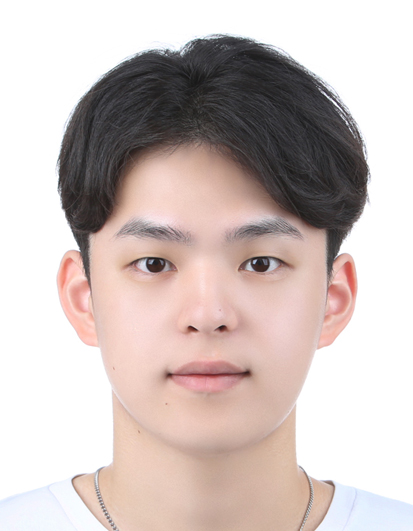
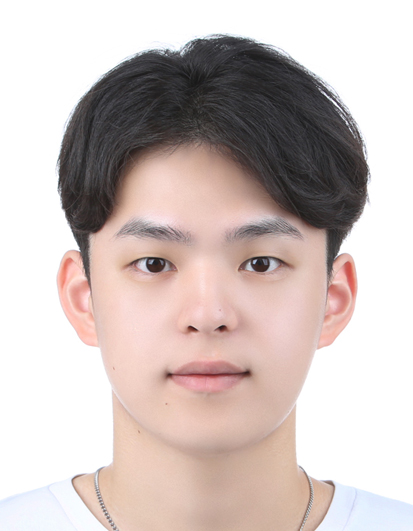
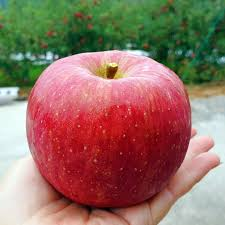
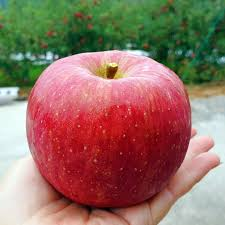
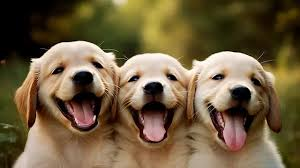
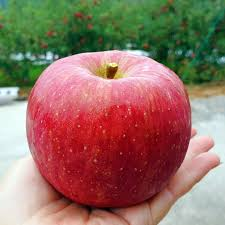
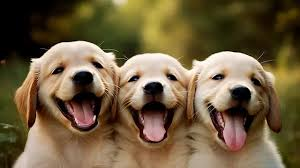

In [29]:
demo.launch()